# 03 — Modeling (NumPy-only Ridge Regression) trên Airbnb NYC 2019

**Mục tiêu**
- Đọc gói dữ liệu đã xử lý (`.npz`) từ bước 02
- Chia `train/val/test`, thiết lập **baseline**
- Dò **alpha** cho Ridge bằng K-Fold CV (chỉ NumPy)
- Huấn luyện mô hình cuối cùng, đánh giá trên **test**
- Vẽ các biểu đồ chẩn đoán, xem nhanh trọng số

**Lí do chọn Ridge + K-Fold:** Ridge (L2) ổn định nghiệm và giảm overfit cho hồi quy tuyến tính; tham số `alpha` điều khiển mức co giãn hệ số, cần chọn bằng **Cross-Validation** để tổng quát hoá tốt hơn. Chuẩn hoá đặc trưng (Z-score) là thói quen tốt trước khi ước lượng tuyến tính/regularization

**Chỉ số đánh giá**: RMSE, MAE, R² (R² có thể âm khi mô hình tệ hơn baseline dự đoán trung bình)

## 0) Thiết lập & import

In [1]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt

# Thêm src/ vào PYTHONPATH
# Xác định ROOT sao cho linh hoạt khi mở notebook từ project 
ROOT = Path.cwd()
if not (ROOT / "src").exists() and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

# Import API trong src/__init__.py
from src import (
    # data I/O
    load_processed_npz,
    # modeling
    split_train_val_test_idx, stratified_train_val_test_idx,
    fit_linear_pipeline, predict_linear_pipeline,
    evaluate_regression, baseline_predict_mean,
    cv_ridge_alphas,
    # visualization
    plot_pred_vs_true, plot_residuals_hist,
)

# Hiển thị số thập phân gọn hơn
np.set_printoptions(suppress=True, linewidth=120)

# data paths
DATA_PROCESSED = ROOT / "data" / "processed"
INP = DATA_PROCESSED / "ab_nyc_2019_processed.npz"

## 1) Đọc dữ liệu đã xử lý  (.npz) từ bước 02_preprocessing

In [2]:
X, y, feature_names, encoders, meta = load_processed_npz(str(INP))

print("Số mẫu:", X.shape[0])
print("Số đặc trưng:", X.shape[1])
print("Một vài tên đặc trưng (10 đặc trưng):", feature_names[:10])
print("Metadata:", meta)

Số mẫu: 48877
Số đặc trưng: 199
Một vài tên đặc trưng (10 đặc trưng): ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'neighbourhood_group=Bronx', 'neighbourhood_group=Brooklyn', 'neighbourhood_group=Manhattan']
Metadata: {'kept_geo_ratio': 0.9996318641987934, 'median_imputed': {}, 'note': 'clip target [1,99] pct; one-hot cat; impute median for numeric.'}


## 2) Chia tập train/val/test 
random có seed

In [3]:
idx_tr, idx_va, idx_te = stratified_train_val_test_idx(
    y, val_size=0.2, test_size=0.2, seed=42,
    task="regression",      # hoặc 'auto' 
    n_bins=10,              
    strategy="quantile",    # giữ tỉ lệ tốt hơn uniform
)

X_tr, y_tr = X[idx_tr], y[idx_tr]
X_va, y_va = X[idx_va], y[idx_va]
X_te, y_te = X[idx_te], y[idx_te]

print(f"train: {X_tr.shape}, val: {X_va.shape}, test: {X_te.shape}")

train: (29337, 199), val: (9770, 199), test: (9770, 199)


## 3) Baseline: dự đoán trung bình 
dùng mean của y_train

In [4]:
yhat_base_val = baseline_predict_mean(y_tr, len(y_va))
yhat_base_te  = baseline_predict_mean(y_tr, len(y_te))

print("Baseline (val):", evaluate_regression(y_va, yhat_base_val))
print("Baseline (test):", evaluate_regression(y_te, yhat_base_te))

Baseline (val): {'rmse': 121.69191537045825, 'mae': 80.85779323876503, 'r2': -4.667924285772784e-06}
Baseline (test): {'rmse': 121.19114094632808, 'mae': 80.53704959439852, 'r2': -1.6508092484324166e-05}


## 4) K-Fold CV để chọn `alpha` cho Ridge
- Dùng K-Fold thay vì single split giúp ước lượng ổn định hơn khi chọn siêu tham số. 
- `alpha` càng lớn -> hệ số càng bị co (shrink) mạnh

**Lưu ý**: Tránh `alpha = 0`, do nghiệm thường dễ suy biến khi đa cộng tuyến => Ridge giải quyết bằng L2 regularization

In [5]:
# Lưới alpha theo logspace
alphas = np.logspace(-6, 2, 12)

cv = cv_ridge_alphas(
    X_tr, y_tr, alphas=alphas, k=5,
    use_standardize=True, use_bias=True, seed=42,
    use_stratified=True, stratify_task="regression", stratify_n_bins=10, stratify_strategy="quantile",
    target_transform=np.log1p,    # train trên log-price
    target_inverse=np.expm1,      # eval trên thang giá gốc
)
cv["best"], len(cv["scores"])

({'alpha': 1e-06,
  'rmse_mean': 100.02524434490142,
  'mae_mean': 52.31927263192912,
  'r2_mean': 0.3299139981230897},
 12)

### Bảng điểm CV, sắp theo RMSE tăng dần

In [6]:
# Chuyển dict -> mảng NumPy
scores = cv["scores"]
alphas = np.array([s["alpha"]    for s in scores], dtype=float)
rmse_m = np.array([s["rmse_mean"] for s in scores], dtype=float)
mae_m  = np.array([s["mae_mean"]  for s in scores], dtype=float)
r2_m   = np.array([s["r2_mean"]   for s in scores], dtype=float)

# Sắp theo RMSE tăng dần
order = np.argsort(rmse_m)  # dùng chỉ số để truy cập các mảng song song
# In gọn top-10
k = min(10, len(order))
print(f"Top-{k} alphas from CV:")
print(f"{'rank':>4} {'alpha':>10} {'rmse':>10} {'mae':>10} {'r2':>8}")
for r in range(k):
    j = order[r]
    print(f"{r+1:4d} {alphas[j]:10.3e} {rmse_m[j]:10.4f} {mae_m[j]:10.4f} {r2_m[j]:8.4f}")

Top-10 alphas from CV:
rank      alpha       rmse        mae       r2
   1  1.000e-06   100.0252    52.3193   0.3299
   2  5.337e-06   100.0252    52.3193   0.3299
   3  2.848e-05   100.0252    52.3193   0.3299
   4  1.520e-04   100.0252    52.3193   0.3299
   5  8.111e-04   100.0252    52.3193   0.3299
   6  4.329e-03   100.0253    52.3193   0.3299
   7  2.310e-02   100.0254    52.3192   0.3299
   8  1.233e-01   100.0259    52.3188   0.3299
   9  6.579e-01   100.0285    52.3170   0.3299
  10  3.511e+00   100.0432    52.3073   0.3297


### Trực quan hoá 

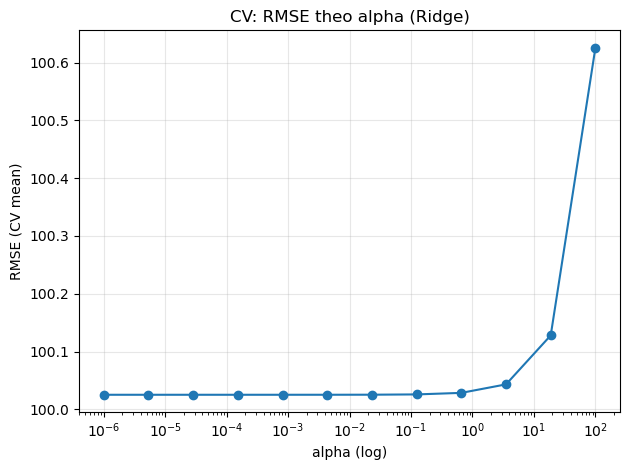

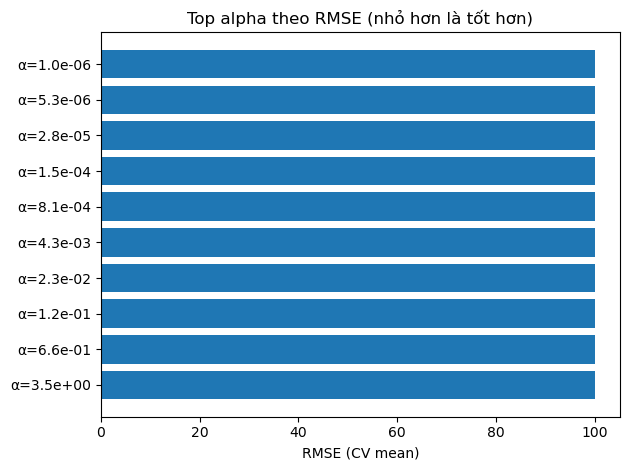

In [7]:
# 1) Đường RMSE theo alpha (trục x log-scale)
plt.figure()
plt.plot(alphas, rmse_m, marker="o")
plt.xscale("log")  # trục x log
plt.xlabel("alpha (log)"); plt.ylabel("RMSE (CV mean)")
plt.title("CV: RMSE theo alpha (Ridge)")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 2) Bar chart top-10 alpha tốt nhất (RMSE nhỏ nhất)
alphas_sorted = alphas[order]
rmse_sorted   = rmse_m[order]
labels = [f"α={a:.1e}" for a in alphas_sorted[:k]]

plt.figure()
# Vẽ từ dưới lên để thanh nhỏ nhất ở trên cùng (đảo ngược)
plt.barh(labels[::-1], rmse_sorted[:k][::-1])
plt.xlabel("RMSE (CV mean)")
plt.title("Top alpha theo RMSE (nhỏ hơn là tốt hơn)")
plt.tight_layout()

## 5) Huấn luyện mô hình cuối cùng
- Dùng `alpha_best` từ cross-validation
- Fit trên **train + val** rồi đánh giá trên **test** 

In [8]:
scores_sorted = [scores[i] for i in order]

alpha_best = float(scores_sorted[0]['alpha'])
print("alpha_best =", alpha_best)

# Gộp train+val
idx_trva = np.concatenate([idx_tr, idx_va], axis=0)
X_trva, y_trva = X[idx_trva], y[idx_trva]

# train lại trên train+val với alpha tốt nhất
model = fit_linear_pipeline(
    X_trva, y_trva,
    alpha=alpha_best, use_standardize=True, use_bias=True,
    target_transform=np.log1p, target_inverse=np.expm1,
)

# Dự đoán & đánh giá
yhat_te = predict_linear_pipeline(X_te, model)
test_metrics = evaluate_regression(y_te, yhat_te)
test_metrics

alpha_best = 1e-06


{'rmse': 98.18041070200655, 'mae': 51.14901417708483, 'r2': 0.3436807989505132}

## 6) Visalization
- Biểu đồ dự đoán vs thực tế
- Biểu đồ phân phối sai số (residuals)

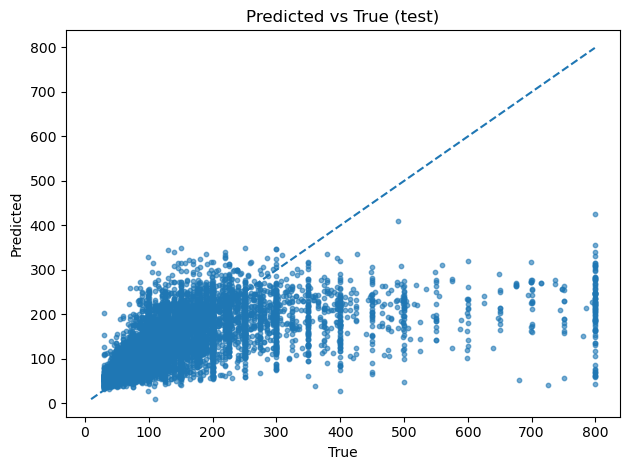

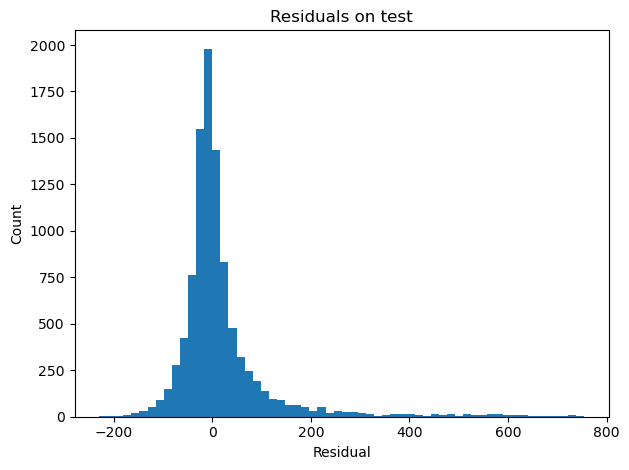

In [9]:
plot_pred_vs_true(y_te, yhat_te, title="Predicted vs True (test)")
plot_residuals_hist(y_te, yhat_te, bins=60, title="Residuals on test")

## 7) Xem nhanh trọng số mô hình
- Mô hình đang hoạt động trên **không gian đã chuẩn hoá** (Z-score)
- Có thể quy đổi về **đơn vị gốc** để dễ diễn giải:
  - Nếu `y = b + Σ w_j * (x_j - mean_j)/std_j`, thì:
    - hệ số gốc: `coef_j = w_j / std_j`
    - intercept gốc: `b0 = b - Σ w_j * mean_j / std_j`
- Với one-hot, cách quy đổi vẫn hợp lệ vì (0/1 - mean)/std  
- Trọng số lớn về trị tuyệt đối **không** đồng nghĩa nguyên nhân, chỉ là tuyến tính ước lượng

In [10]:
w = model["w"]
use_bias = model["use_bias"]
mean = model["mean"]; std = model["std"].copy()
std[std == 0] = 1.0

if use_bias:
    b = w[0]
    w_no_bias = w[1:]
else:
    b = 0.0
    w_no_bias = w

# Quy đổi về đơn vị gốc
coef_unstd = w_no_bias / std
intercept_unstd = b - np.sum(w_no_bias * mean / std)

# Ghép bảng trọng số
coef_table = []
for name, c in zip(feature_names, coef_unstd):
    coef_table.append((name, float(c)))
coef_table = sorted(coef_table, key=lambda t: -abs(t[1]))

print("Intercept (original scale):", float(intercept_unstd))
print("\nTop 15 |coef| (original scale):")
for name, c in coef_table[:15]:
    print(f"{name:40s} {c:+.4f}")

Intercept (original scale): 279.92471159506715

Top 15 |coef| (original scale):
geo_d2c_7                                -8.0360
geo_d2c_6                                +6.6139
geo_d2c_2                                -4.9852
geo_d2c_4                                +3.4432
geo_d2c_5                                +3.3994
geo_d2c_0                                +3.2782
longitude                                +2.5783
geo_d2c_3                                -2.1018
latitude                                 -2.0995
neighbourhood=Riverdale                  +1.1879
room_type=Shared room                    -0.6591
neighbourhood=Edgemere                   -0.4737
neighbourhood=Tribeca                    +0.4663
neighbourhood=City Island                +0.4629
neighbourhood=Sunnyside                  -0.4520


## 8) Lưu model (optional)
Lưu dict model (NumPy-only) để dùng lại nếu cần

In [11]:
MODEL_DIR = ROOT / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
OUT_MODEL = MODEL_DIR / f"ridge_np_alpha{alpha_best:.1e}.npz"

# Lưu model + meta
np.savez_compressed(
    OUT_MODEL,
    model=np.array(model, dtype=object),
    alpha=np.array(alpha_best),
    feature_names=np.array(feature_names, dtype="U"),
    metrics=np.array(test_metrics, dtype=object),
)
print("Saved:", OUT_MODEL.resolve())

Saved: /home/khoaoe/ds_programming/lab/lab02/airbnb/models/ridge_np_alpha1.0e-06.npz
